In [1]:
using PyPlot

In [2]:
push!(LOAD_PATH, ".");
using quantum
names(quantum)

16-element Array{Symbol,1}:
 :P_Orthogonal  
 :P_Unitary     
 :apply_ising!  
 :apply_kick!   
 :apply_unitary!
 :base_state    
 :projector     
 :quantum       
 :random_state  
 :sigma_x       
 :sigma_y       
 :sigma_z       
 :sigmas        
 :staircase     
 :testbit       
 :unfolding     

In [3]:
hadamard = [1 1; 1 -1]/sqrt(2.)

2x2 Array{Float64,2}:
 0.707107   0.707107
 0.707107  -0.707107

In [4]:
function concat_ancilla(psi, n=2)
    dim = length(psi)
    psi_anc = zeros(Complex{Float64}, dim*2*n)
    psi_anc[1:dim] = psi
    return psi_anc
end

concat_ancilla (generic function with 2 methods)

In [5]:
function apply_control_not!(psi, control_qubit, target_qubit)
    psi_i_temp = copy(psi)
    mov = max(control_qubit,target_qubit)
    for i = 0:length(psi)-1
        if testbit(i,control_qubit) & !testbit(i,target_qubit)
            psi[i+1] = psi_i_temp[i+1+2^mov]
        elseif testbit(i,control_qubit) & testbit(i,target_qubit)
            psi[i+1] = psi_i_temp[i+1-2^mov]
        end
    end
end

function apply_control_phase!(psi, control_qubit, target_qubit,angle)
    phase=exp(im*angle)
    for i = 0: length(psi)-1
        if testbit(i,control_qubit) & testbit(i,target_qubit)
            psi[i+1]*=phase
        end
    end
end 

apply_control_phase! (generic function with 1 method)

In [6]:
function encoder(psi)
    psi_encode = concat_ancilla(psi, 2)
    apply_control_not!(psi_encode, 0, 1)
    apply_control_not!(psi_encode, 0, 2)
    return psi_encode
end

encoder (generic function with 1 method)

In [7]:
function error_generator(Err, psi, p, n)
    psi_err = copy(psi)
    for i=0:n-1
        if rand()< p
            apply_unitary!(psi_err, Err, n-1-i)
        end
    end
    return psi_err
end

error_generator (generic function with 1 method)

In [ ]:
function count_coincidence(p::Array{Float64,1}, enc=false, N=10000, epsilon=1.0e-6)
    coincidences = zeros(length(p))
    n = 1
    for j in 1:length(p)
        for i=1:N
            psi = random_state(2^n)
            if enc
                psi_enc = encoder(psi)
                psi_enc_err = copy(psi_enc)
                
                for i = 0:2
                    apply_unitary!(psi_enc_err, hadamard, i)
                end
                
                psi_enc_err = error_generator(sigma_z, psi_enc_err, p[j], n+2)
                
                for i = 0:2
                    apply_unitary!(psi_enc_err, hadamard, i)
                end
                
                if norm(psi_enc - psi_enc_err) < epsilon
                    coincidences[j] += 1.
                end
            else
                psi_err = error_generator(sigma_z, psi, p[j], n)
                if norm(psi_err - psi) < epsilon
                    coincidences[j] += 1.
                end
            end
        end
    end
    return coincidences/N
end

In [ ]:
p = collect(0:0.05:1);
coincidencias_enc = count_coincidence(p, true);
coincidencias = count_coincidence(p, false);
scatter(p, coincidencias_enc, c = "green")
scatter(p, coincidencias)

In [8]:
function partial_trace_pure_bipartite_mat(state, dim, system)
    dimtotal = length(state)[1]
    dimcomp = Int(dimtotal/dim)
    psi = reshape(state,(dimcomp,dim))'
    if system==1
        psi=conj(psi)
        return psi*psi'
    elseif system==2
        return psi'*psi
    end
end

partial_trace_pure_bipartite_mat (generic function with 1 method)

In [9]:
function error_correction(psi)
    psi_phase = copy(psi)

    psi_anc = concat_ancilla(psi_phase, 2)
    
    apply_control_not!(psi_anc, 0, 4)
    apply_control_not!(psi_anc, 2, 4)
    apply_control_not!(psi_anc, 0, 3)
    apply_control_not!(psi_anc, 1, 3)
    
    ancilla = partial_trace_pure_bipartite_mat(psi_anc, 4, 1)
    
    for i in 1:4
        if abs(ancilla[i,i] - 1.0) < 1e-6
            if i == 2
                apply_unitary!(psi, sigma_x, 1)
            elseif i == 3
                apply_unitary!(psi, sigma_x, 2)
            elseif i == 4
                apply_unitary!(psi, sigma_x, 0)
            end
        end
    end
    
    return psi
end

error_correction (generic function with 1 method)

In [10]:
function count_coincidence_error_correction(p::Array{Float64,1}, case, N=10000,epsilon=1e-6)
    coincidences = zeros(length(p))
    n = 1
    for j in 1:length(p)
        for i=1:N
            psi = random_state(2^n)
            if case == 0
                psi_enc = encoder(psi)
                psi_enc_err = copy(psi_enc)
                
                for i = 0:2
                    apply_unitary!(psi_enc_err, hadamard, i)
                end
                psi_enc_err = error_generator(sigma_z, psi_enc_err, p[j], n+2)
                for i = 0:2
                    apply_unitary!(psi_enc_err, hadamard, i)
                end
                
                psi_enc_corrected = error_correction(psi_enc_err)
                
                if norm(psi_enc - psi_enc_corrected) < epsilon
                    coincidences[j] += 1.
                end
            elseif case == 1
                psi_enc = encoder(psi)
                psi_enc_err = copy(psi_enc)
                
                for i = 0:2
                    apply_unitary!(psi_enc_err, hadamard, i)
                end
                
                psi_enc_err = error_generator(sigma_z, psi_enc_err, p[j], n+2)
                
                for i = 0:2
                    apply_unitary!(psi_enc_err, hadamard, i)
                end
                
                if norm(psi_enc - psi_enc_err) < epsilon
                    coincidences[j] += 1.
                end
            elseif case== 2
                psi_err = error_generator(sigma_z, psi, p[j], n)
                if psi == psi_err
                    coincidences[j] += 1.
                end
            end
        end
    end
    return coincidences/N
end

count_coincidence_error_correction (generic function with 3 methods)

In [13]:
p = collect(0:0.01:1);
coincidencias_qec = count_coincidence_error_correction(p, 0);
coincidencias_enc_e = count_coincidence_error_correction(p, 1);
coincidencias_e = count_coincidence_error_correction(p, 2);

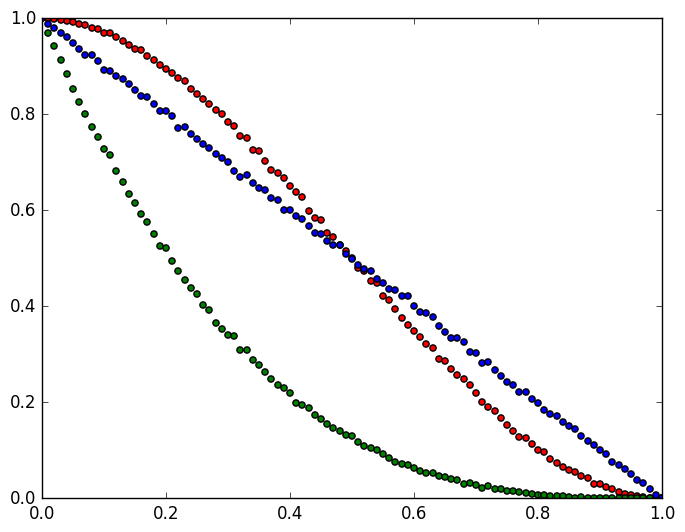

In [14]:
scatter(p, coincidencias_qec, c = "red")
scatter(p, coincidencias_enc_e, c = "green")
scatter(p, coincidencias_e)
xlim([0,1]); ylim([0,1]);